## Exploratory Data Analysis – E-commerce Fraud Data

This notebook explores transaction patterns, user behavior,
and class imbalance to understand fraud characteristics.


📌 Load & Clean

In [1]:
# Exploratory Data Analysis for Fraud Detection
# Allow imports from src/
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.data_loader import load_fraud_data
from src.preprocessing import clean_fraud_data

df = load_fraud_data("../data/raw/Fraud_Data.csv")
df = clean_fraud_data(df)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


📊 Class Imbalance

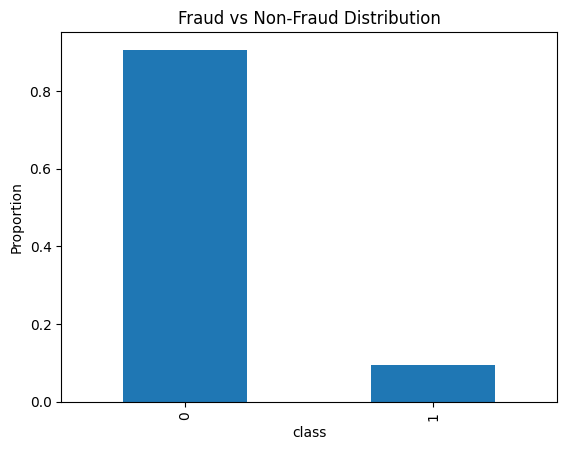

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
df["class"].value_counts(normalize=True).plot(kind="bar")
plt.title("Fraud vs Non-Fraud Distribution")
plt.ylabel("Proportion")
plt.show()


📊 Purchase Value vs Fraud

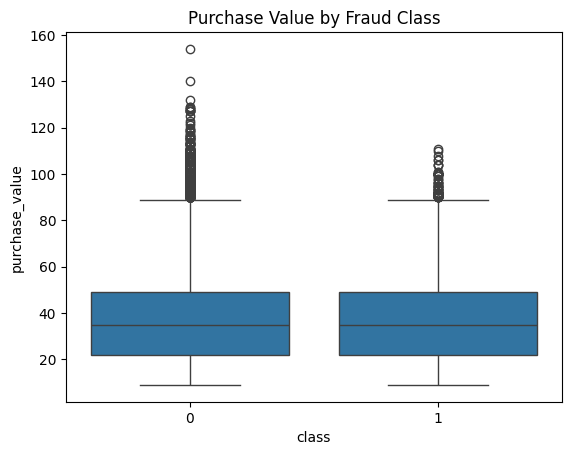

In [3]:
# Purchase Value vs Fraud
sns.boxplot(x="class", y="purchase_value", data=df)
plt.title("Purchase Value by Fraud Class")
plt.show()


📊 Time Since Signup vs Fraud

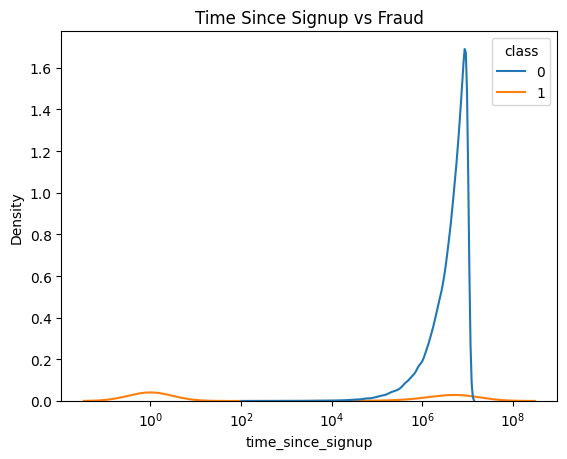

In [4]:
# Time Since Signup vs Fraud
df["time_since_signup"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds()

sns.kdeplot(
    data=df,
    x="time_since_signup",
    hue="class",
    log_scale=True
)
plt.title("Time Since Signup vs Fraud")
plt.show()